This script is used to produce the plots from our OpenAI Gym experiments in our
paper. If you'd like to use this script on your own data, check the README,
and follow the same approach used in the `1_grid_search` section.

# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from qscaled.wandb_utils.one_seed_per_run import ExampleOneSeedPerRunCollector
from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.utils.configs import FittedConfig
from qscaled.core.preprocessing import bootstrap_crossings, select_middle_bs_lr, get_envs, get_utds
from qscaled.utils.plot_utils import set_theme

from qscaled.core.grid_search.linear_fit import get_fit_mean_batch_size

from qscaled.core.fitted.learning_curves import plot_per_env_utd

from qscaled.core.fitted.data_efficiency import (
    compute_data_efficiency_per_env,
    plot_data_efficiency_per_env,
    compute_normalized_times,
    plot_data_efficiency_averaged,
    make_data_pareto_fits,
    plot_utd_data_pareto_fits,
    plot_clean_utd_data_pareto_fit,
    plot_clean_compute_data_pareto_fit,
)
from qscaled.core.fitted.budget import plot_compute_data_isoperformance, plot_budget_extrapolation

In [15]:
config_input = dict(
    sweep_name='dmc_sweep',
    sweep_slope_type='shared',
    max_returns={},
    returns_key='online_returns',
    wandb_collector=None,
    thresholds=[200, 300, 400, 500, 600, 700, 800],
    model_size=4.92e6,  # Number of critic parameters
    budget_delta=1e10,
    budget_extrapolate_top_k=2,
)
fitted_config = FittedConfig(name='dmc_ours', env_step_freq=1000, env_step_start=5000, **config_input)
baseline_config = FittedConfig(name='dmc_baseline_utd2', **config_input)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

In [19]:
ours_df = fetch_zip_data(fitted_config, use_cached=True)
ours_df = select_middle_bs_lr(ours_df)
ours_df = bootstrap_crossings(ours_df, fitted_config.thresholds, fitted_config.name, use_cached=False)
baseline_df = fetch_zip_data(baseline_config, use_cached=True)
baseline_df = bootstrap_crossings(baseline_df, baseline_config.thresholds, baseline_config.name, use_cached=True)
envs = get_envs(ours_df)
utds = get_utds(ours_df)

100%|██████████| 42/42 [00:01<00:00, 21.57it/s]

Average standard deviation across all conditions: 8182.89
Average standard deviation across all conditions: 11988.86


# Visualization

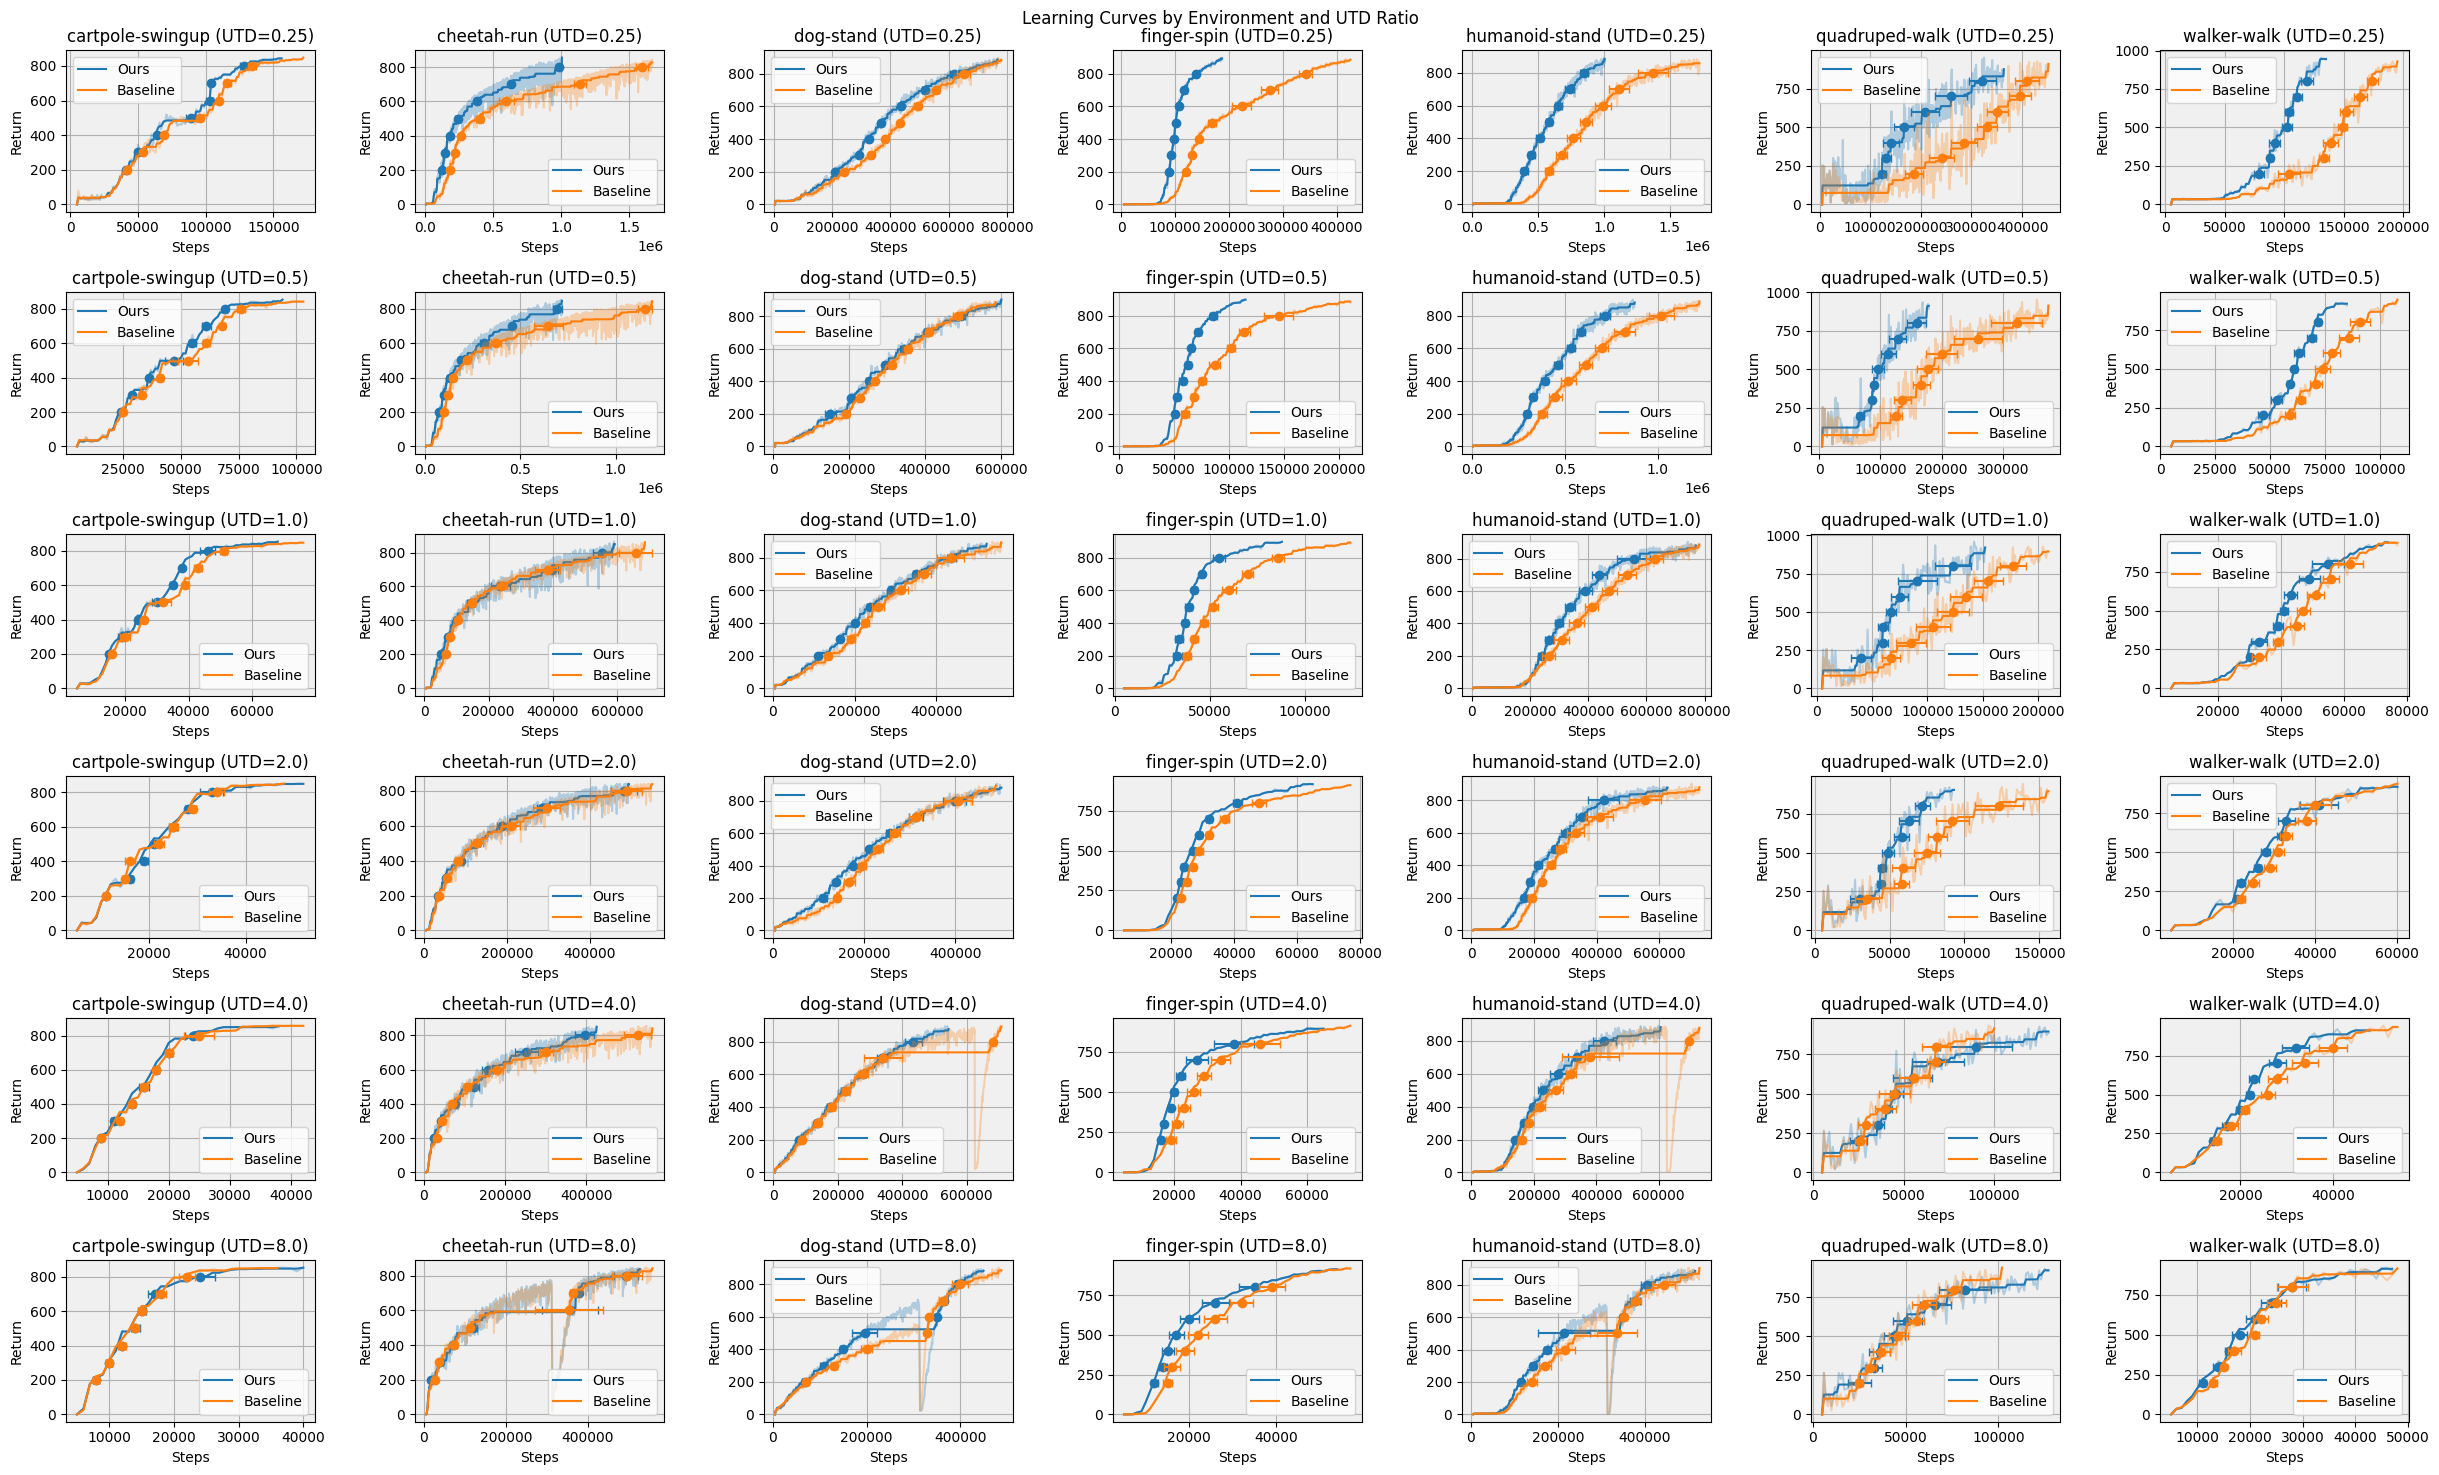

In [20]:
plot_per_env_utd(ours_df, baseline_df, fitted_config.thresholds)

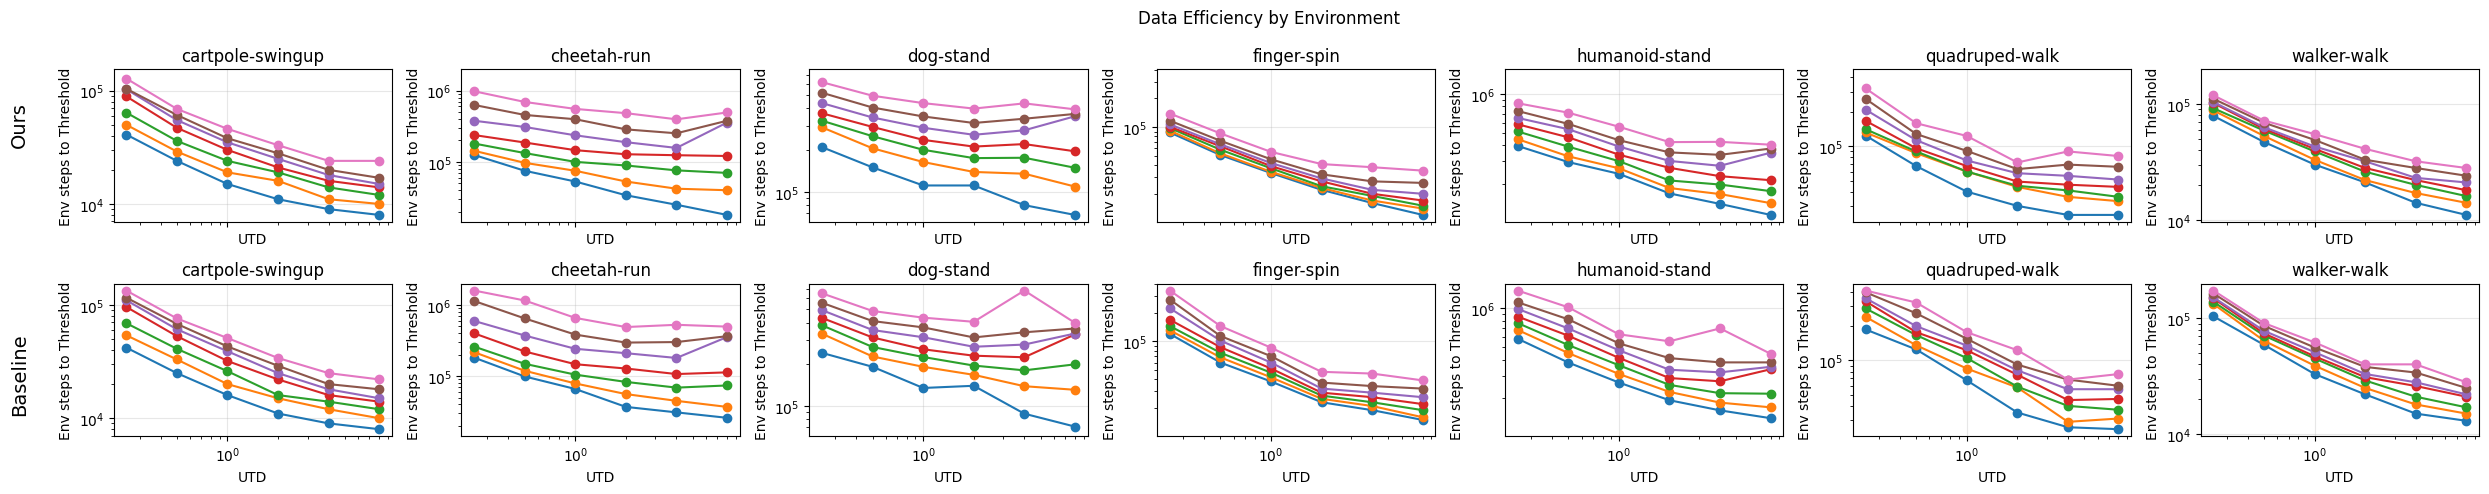

In [21]:
ours_env_data_efficiency_dict = compute_data_efficiency_per_env(ours_df, envs)
baseline_env_data_efficiency_dict = compute_data_efficiency_per_env(baseline_df, envs)
plot_data_efficiency_per_env(ours_env_data_efficiency_dict, baseline_env_data_efficiency_dict, envs)

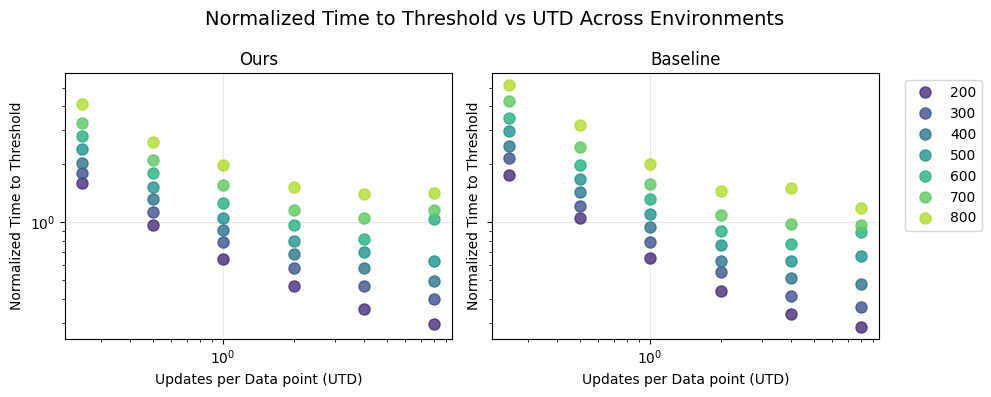

In [22]:
ours_normalized_times_all, ours_mean_normalized_times, ours_median_median = compute_normalized_times(
    ours_env_data_efficiency_dict, envs
)
baseline_normalized_times_all, baseline_mean_normalized_times, baseline_median_median = compute_normalized_times(
    baseline_env_data_efficiency_dict, envs
)
plot_data_efficiency_averaged(
    ours_mean_normalized_times, baseline_mean_normalized_times, utds, fitted_config.thresholds
)

# Asymptotic data efficiency fit

In [23]:
ours_data_pareto_fits = make_data_pareto_fits(
    ours_mean_normalized_times,
    utds,
    len(fitted_config.thresholds),
    output_dir='../outputs',
    save_name=fitted_config.name,
)
baseline_data_pareto_fits = make_data_pareto_fits(
    baseline_mean_normalized_times,
    utds,
    len(fitted_config.thresholds),
    output_dir='../outputs',
    save_name=baseline_config.name,
)

  0%|          | 0/7 [00:00<?, ?it/s]/home/preston/Preston/Berkeley/rail/qscaled-private/qscaled/utils/power_law.py:6: RuntimeWarning: invalid value encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/Preston/Berkeley/rail/qscaled-private/qscaled/utils/power_law.py:6: RuntimeWarning: overflow encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


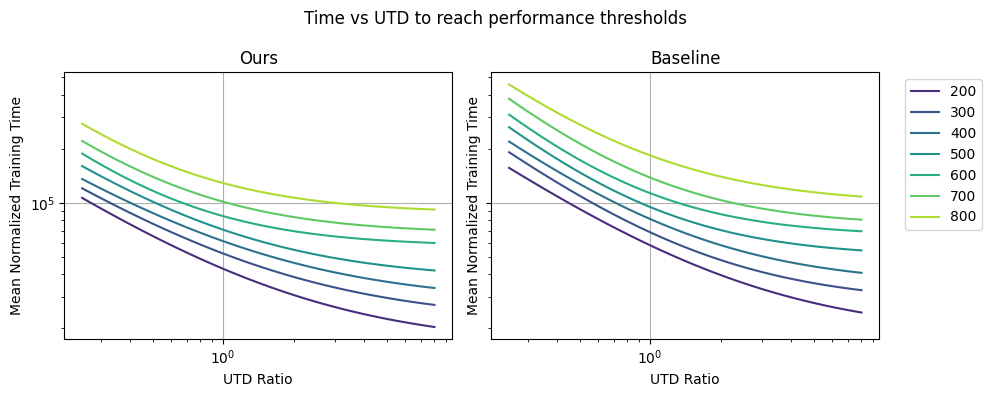

In [24]:
plot_utd_data_pareto_fits(
    ours_data_pareto_fits,
    ours_median_median,
    baseline_data_pareto_fits,
    baseline_median_median,
    utds,
    fitted_config.thresholds,
)

# Final plots

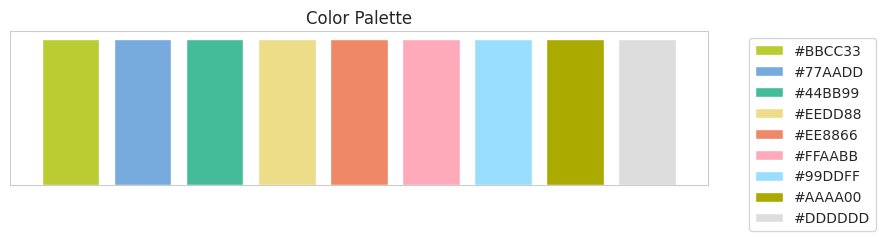

In [25]:
set_theme()

Fits using threshold 800
Ours: D_J = 8.74e+04 * (1 + (σ/0.65)**(-1.09))


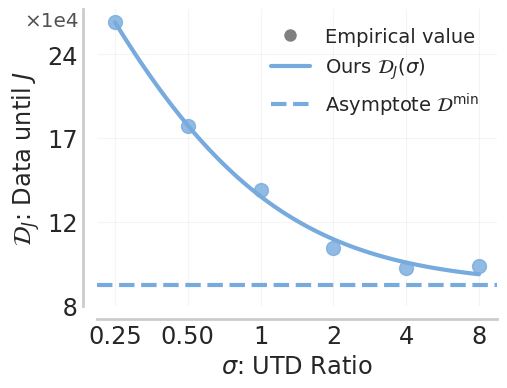

Fits using threshold 800
Ours: D_J = 8.74e+04 * (1 + (σ/0.65)**(-1.09))
Baseline: D_J = 9.84e+04 * (1 + (σ/0.97)**(-1.03))


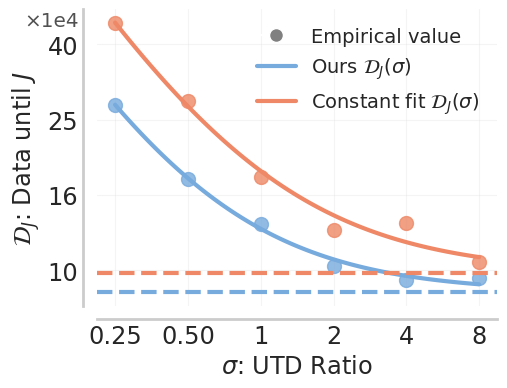

In [35]:
utd_data_pareto_fit_input = dict(
    ours_fits=ours_data_pareto_fits,
    ours_normalized_times_all=ours_normalized_times_all,
    ours_median_median=ours_median_median,
    baseline_fits=baseline_data_pareto_fits,
    baseline_normalized_times_all=baseline_normalized_times_all,
    baseline_median_median=baseline_median_median,
    utds=utds,
    thresholds=fitted_config.thresholds,
    threshold_idx=-1,
    yscale='1e4',
)

plot_clean_utd_data_pareto_fit(**utd_data_pareto_fit_input, ylim=(8e4, 24e4), show_baseline=False)
plot_clean_utd_data_pareto_fit(**utd_data_pareto_fit_input, ylim=(10e4, 40e4), show_baseline=True)

Fits using threshold 800


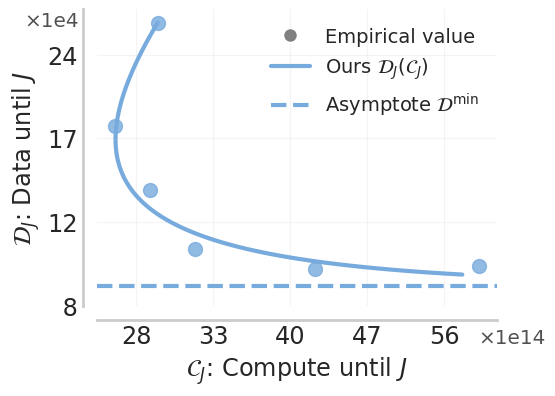

Fits using threshold 800


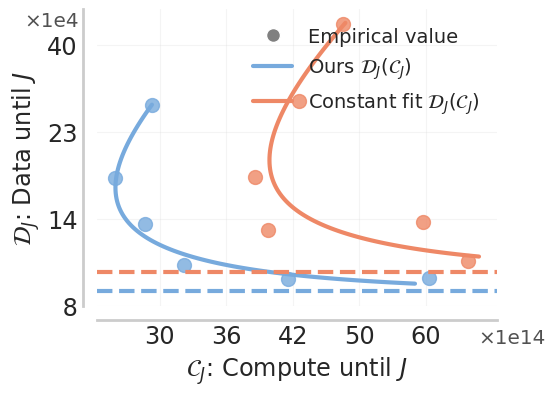

In [52]:
utd_to_batch_size_fn = get_fit_mean_batch_size(
    envs, '../outputs', fitted_config.sweep_name, fitted_config.sweep_slope_type
)
compute_data_pareto_fit_input = dict(
    ours_fits=ours_data_pareto_fits,
    ours_normalized_times_all=ours_normalized_times_all,
    ours_median_median=ours_median_median,
    baseline_fits=baseline_data_pareto_fits,
    baseline_normalized_times_all=baseline_normalized_times_all,
    baseline_median_median=baseline_median_median,
    utd_to_batch_size_fn=utd_to_batch_size_fn,
    model_size=fitted_config.model_size,
    utds=utds,
    thresholds=fitted_config.thresholds,
    threshold_idx=-1,
    xscale='1e14',
    yscale='1e4',
)

plot_clean_compute_data_pareto_fit(
    **compute_data_pareto_fit_input, show_baseline=False, xlim=(28e14, 56e14), ylim=(8e4, 24e4)
)
plot_clean_compute_data_pareto_fit(
    **compute_data_pareto_fit_input, show_baseline=True, xlim=(30e14, 60e14), ylim=(8e4, 40e4)
)

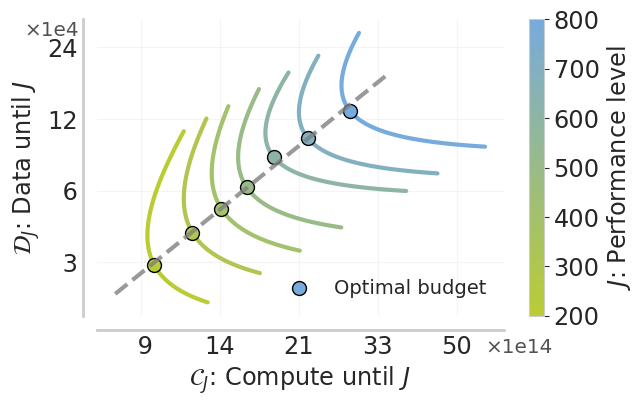

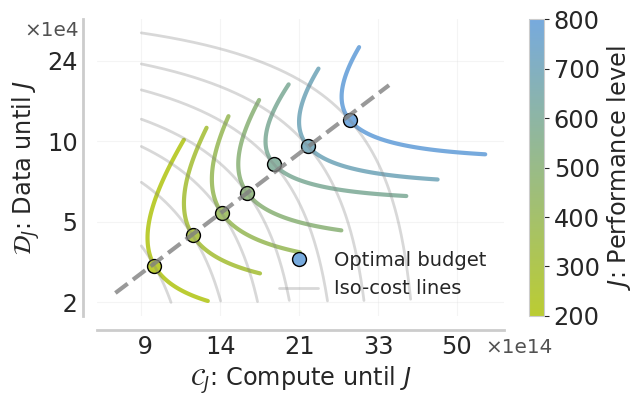

In [61]:
compute_data_isoperformance_input = dict(
    fits=ours_data_pareto_fits,
    normalized_times_all=ours_normalized_times_all,
    median_median=ours_median_median,
    thresholds=fitted_config.thresholds,
    utd_to_batch_size_fn=utd_to_batch_size_fn,
    utds=utds,
    model_size=fitted_config.model_size,
    delta=fitted_config.budget_delta,
    xscale='1e14',
    yscale='1e4',
)

min_points_compute, min_points_data, min_points_utd = plot_compute_data_isoperformance(**compute_data_isoperformance_input, xlim=(9e14, 50e14), ylim=(3e4, 24e4))
_ = plot_compute_data_isoperformance(**compute_data_isoperformance_input, show_isocost=True, xlim=(9e14, 50e14), ylim=(2e4, 24e4), isocost_xlim=(9e14, 90e14), isocost_ylim=(2e4, 35e4))

σ* = 1.69e+15 × F_J^-0.98


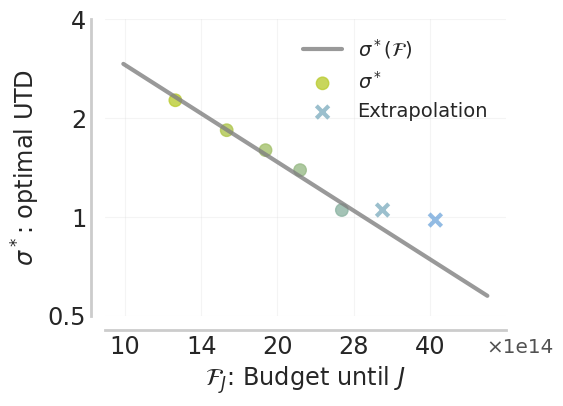

In [83]:
plot_budget_extrapolation(
    min_points_compute,
    min_points_data,
    min_points_utd,
    delta=fitted_config.budget_delta,
    thresholds=fitted_config.thresholds,
    n_extrapolate_points=fitted_config.budget_extrapolate_top_k,
    xlim=(10e14, 40e14),
    xscale='1e14',
    ylim=(0.5, 4),
)